
# i2DBSCAN for DEBUGING

### This code works for root files



In [1]:
from __future__ import division
import time
def pedsub(img,pedarr):
    return img - pedarr
    
def zsfullres(img_sub,noisearr,nsigma=1):
    img_zs = np.where(img_sub > nsigma * noisearr, img_sub, 0)
    return img_zs

def noisearray(th2):
    noisearr = np.zeros( (th2.GetNbinsX(),th2.GetNbinsY()) )
    for ix in range(th2.GetNbinsX()):
        for iy in range(th2.GetNbinsY()):
            noisearr[ix][iy] = th2.GetBinError(ix+1,iy+1)
    return noisearr

def findedges(ybox,xbox,rescale):
    from skimage.measure import find_contours
    from numpy import zeros
    from scipy.ndimage import uniform_filter
    
    mm = zeros([rescale,rescale],dtype=int)
    mm[ybox,xbox]=10000
    mm = uniform_filter(mm, size=5)
    contours = find_contours(mm, 0.9)
    return contours

def noisereductor(edges,rescale):
    tpx = 10

    for i in range(1,rescale-2):
        for j in range(1,rescale-2):
            spx = edges[i,j]
            mpx = (np.sum(edges[i-1:i+2,j-1:j+2])-spx)/8.
            if np.abs(spx - mpx) > tpx :
                edges[i,j] = mpx
            if (mpx < 0.45):
                edges[i,j] = 0
    return edges

def ordena_pontos(X):
    n = len(X)
    kern = []
    for i in range(n):
        x = X[i,0] * np.ones(n)
        y = X[i,1] * np.ones(n)
        e = np.e
        fkernx = ((2*np.pi)**-0.5)*(e)**(-0.5*(x-X[:,0])**2)
        fkerny = ((2*np.pi)**-0.5)*(e)**(-0.5*(y-X[:,1])**2)
        kern.append(sum(fkernx)*sum(fkerny)/n)
    
    from operator import itemgetter
    newdata = np.zeros([n,3])
    newdata[:,0] = X[:,0]
    newdata[:,1] = X[:,1]
    newdata[:,2] = np.asarray(kern)
    newdatalist= sorted(newdata,key=itemgetter(2),reverse=1)
    newdataord = np.zeros([n,2],dtype=int)
    for i in range(n):
        newdataord[i,0] = int(newdatalist[i][0])
        newdataord[i,1] = int(newdatalist[i][1])
    return newdataord


In [2]:
## IMPORTING LIBRARIES

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ROOT
import tools_lib as tl
import sys
sys.path.insert(1, '../')

from iDBSCAN import iDBSCAN
from root_numpy import hist2array
from matplotlib.pyplot import *
from scipy.spatial import distance
from sklearn.cluster import DBSCAN
from ddbscan_ import DDBSCAN
from sklearn import metrics
from IPython.display import set_matplotlib_formats
from scipy.ndimage import gaussian_filter, median_filter


Welcome to JupyROOT 6.14/04


In [ ]:


%matplotlib inline
## Setting plotting parameters
set_matplotlib_formats('png', 'pdf')
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 30, 'linewidths':0}
cmapcolor = 'gray' # or 'viridis'
vmin      = 99
vmax      = 125
figsizeX  = 12 
figsizeY  = 12

## Setting Debug Flags

flag_full_image     = 1
flag_rebin_image    = 1
flag_edges_image    = 1
flag_first_it       = 1
flag_stats          = 1


## Setting environments variables

rescale     = 512
cimax       = 200
nsigma      = 1.3        # numero di sigma sopra il piedistallo

## Setting i2DBSCAN parameters

iterative     = 4
tip           = '3D'               # 3D

scale = 4

if tip == '3D':
    #vector_eps         =  [1,   2.5,  5.8,  4]    #[ 3,    5,  7,  9]   #[2.26, 3, 3.5, 4]     #[2, 3, 3.5, 4]      #FOR FNG    #[2.26, 3.5, 2.8, 6]
    #vector_min_samples =  [1, 104, 30, 20]         #[30,  200,  100, 100] #[30,  150,  80, 40]   #[30,  55,  28, 13]    #[3,  55,  28, 13]            # [2, 30, 6, 2]
    vector_eps         =  [5.8,   2.5,  5.8,  4]
    vector_min_samples =  [30, 104, 30, 20]
    #vector_eps         = list(np.array(vector_eps, dtype=float)/scale)
    #vector_min_samples = list(np.array(vector_min_samples, dtype=float)/scale)
    eps = 5.8
    min_pts = 30
else:
    vector_eps         = [1, 2.9, 3.2, 4]
    vector_min_samples = [4,  18,  17, 7]
    eps = 3.2
    min_pts = 17

cuts = [1500, 400]                # the cut on the length of the track for iteration 1 and 2
cuts = list(np.array(cuts, dtype=float)/scale)

## File folder
evt               = '00053'#'00016'         # Use always FIVE caracters
numrun            = '02097'#'00724'         # Use always FIVE caracters
formattype        = 'mid'            # If the root files comes from h5 conversion use = 'h5'
filedir           = '../'   # Folder where the root file is placed
peddir            = '../pedestals/'   # Folder where the pedestal file is placed
expo              = '02316'             # Exposure time of the pedestal in ms

## Loading image for analysis
# otherwise use 'mid'
if formattype == 'mid':
    imagename     = 'histograms_Run'
    picname       = 'pic_run%s_ev%d' % (numrun,int(evt))
else:
    imagename     = 'histogram_Run'
    picname       = 'run%d_%s' % (int(numrun),evt)
    
filename = '%s%s%s.root' % (filedir,imagename,numrun)

print('Filename: %s' % (filename))
print('Picname: %s' % (picname))
    
tf2 = ROOT.TFile.Open(filename)
imageth2 = tf2.Get(picname)
image = hist2array(imageth2)
tf2.Close()

if flag_full_image == 1:
    fig = plt.figure(figsize=(figsizeX, figsizeY))
    plt.imshow(image,cmap=cmapcolor, vmin=vmin,vmax=vmax,origin='lower' )
    plt.title("Original Image")
    plt.colorbar()
    
    fig = plt.figure(figsize=(figsizeX, figsizeY))
    plt.imshow(image,cmap=cmapcolor, vmin=95,vmax=105,origin='lower' )
    plt.title("Original Image")
    plt.colorbar()

print('[Image Loaded]')

# Loading Pedestal files


tf2ped  = ROOT.TFile.Open('%spedmap_run%s_rebin1.root' % (peddir,expo))  # PEDESTAL MAP
pedmap  = tf2ped.Get('pedmap').Clone()                               # Getting the pedmap
pedmap.SetDirectory(None)
m_image = hist2array(pedmap)

s_image = noisearray(pedmap)

tf2ped.Close()


img_cimax = np.where(image < cimax, image, 0)
img_fr_sub = pedsub(img_cimax,m_image)
img_fr_zs  = zsfullres(img_fr_sub,s_image,nsigma=nsigma)


print('[Pedestal Loaded]')

# Subtracting Pedestal from Image
rebin_image     = tl.rebin(image, (rescale, rescale))

edges  = tl.rebin(img_fr_zs,(rescale, rescale))
edges = noisereductor(edges,rescale)
edcopy = edges.copy()
edcopyMedian = median_filter(edcopy, size=4)
       
points = np.array(np.nonzero(np.round(edcopyMedian))).astype(int).T
lp = points.shape[0]
print('Numero de pontos: %d' % (lp))


if flag_rebin_image == 1:
    fig = plt.figure(figsize=(figsizeX, figsizeY))
    plt.imshow(rebin_image, cmap=cmapcolor, vmin=vmin, vmax=vmax, origin='lower' )
    plt.title("Rebinned Image")
    
if flag_edges_image == 1:
#     fig = plt.figure(figsize=(figsizeX, figsizeY))
#     plt.imshow(edges, cmap=cmapcolor, vmin=0, vmax=1, origin='lower' )
#     plt.title("Edges Image")
    f,ax = plt.subplots(1,2,figsize=(40,20))
    ax[0].imshow(edges, cmap=cmapcolor, vmin=0, vmax=1, origin='lower' )
    ax[0].set_title('Edges after pedestal subtraction')
    ax[1].imshow(edcopyMedian, cmap=cmapcolor, vmin=0, vmax=1, origin='lower' )
    ax[1].set_title('Edges after Filtering')


print('[Edges Calculated]')

## Adding or not the third dimension
X = points.copy()

# if tip == '3D':
#     lp = len(points)
#     Xl = list(X.copy())
#     for cor in X:
#         for count in range(0,np.int(np.round(rebin_image[cor[0],cor[1]] - rebin_th_image[cor[0],cor[1]]) - 1)):
#             Xl.append(cor)
#     X = np.array(Xl)
#     np.save('corImg.npz',X)
#     print('[3D Method]')
# else:
#     print('[2D Method]')

if tip=='3D':
    Xl = [(ix,iy) for ix,iy in points]          # Aux variable to simulate the Z-dimension
    X1 = np.array(Xl).copy()                    # variable to keep the 2D coordinates
    for ix,iy in points:                        # Looping over the non-empty coordinates
        nreplicas = int(edges[ix,iy])-1
        for count in range(nreplicas):                                # Looping over the number of 'photons' in that coordinate
            Xl.append((ix,iy))                              # add a coordinate repeatedly 
    X = np.array(Xl)                                        # Convert the list to an array
    print('[3D Method]')
else:
    #     print('[2D Method]')
    X = points.copy()
    #X1 = X
    
## STARTING THE CLUSTERING
### Defining some environment variables for i2DBSCAN
#------------------------------------------------------------------
#Modify path if in another PC
#np.save('datateste'+evt,X)

#tst = []
#for i in range(30):
t0 = time.time()
clusters = DDBSCAN(eps=eps, epsransac = 15.5, min_samples = min_pts).fit(X)
#tst.append(len(set(clusters.labels_[:,0])) - (1 if -1 in clusters.labels_[:,0] else 0))
#if len(set(clusters.labels_[:,0])) - (1 if -1 in clusters.labels_[:,0] else 0) != 21:
#   break
t1 = time.time()
clusters_teste = DBSCAN(eps=eps,min_samples=min_pts).fit(X)
t2 = time.time()
#clusters = iDBSCAN(iterative = 0, vector_eps = vector_eps, vector_min_samples = vector_min_samples, cuts = cuts, flag_plot_noise = 0 ).fit(X)
#------------------------------------------------------------------ 

#if tip == '3D':
#    teste = clusters.tag_
#    clusters.labels_ = clusters.labels_[range(0,lp)]
#    clusters.tag_ = clusters.tag_[range(0,lp)]
#    X = points.copy()
#print('[i2DBSCAN Calculated]')

if flag_stats == 1:
    print('[Statistics]')
    n_clusters_ = len(set(clusters.labels_[:,0])) - (1 if -1 in clusters.labels_[:,0] else 0)
    print("Total number of Clusters: %d" % (n_clusters_))
    
    
if flag_first_it == 1:
    print('[Plotting 1st iteration]')
    u,indices = np.unique(clusters.labels_[:,0],return_index = True)
    
    clu = [X[clusters.labels_[:,0] == i] for i in range(len(set(clusters.labels_[:,0])) - (1 if -1 in clusters.labels_[:,0] else 0))]
    clu_tes = [X[clusters_teste.labels_ == i] for i in range(len(set(clusters_teste.labels_)) - (1 if -1 in clusters_teste.labels_ else 0))]
    fig = plt.figure(figsize=(figsizeX, figsizeY))
    plt.imshow(rebin_image,cmap=cmapcolor, vmin=vmin,vmax=vmax,origin='lower' )
    plt.title("Clusters found DDBSCAN")

    for j in range(0,np.shape(clu)[0]):

        ybox = clu[j][:,0]
        
        xbox = clu[j][:,1]

        if (len(ybox) > 0) and (len(xbox) > 0):
            contours = findedges(ybox,xbox,rescale)
            for n, contour in enumerate(contours):
                plt.plot(contour[:, 1],contour[:, 0], '-r',linewidth=2.5)
        

        

Filename: ../histograms_Run02097.root
Picname: pic_run02097_ev53
[Image Loaded]
[Pedestal Loaded]
Numero de pontos: 9021
[Edges Calculated]
[3D Method]
Clusters found in DBSCAN: 33
The point 882 has been assigned as part of a good fit
The point 4784 has been assigned as part of a good fit
The point 5845 has been assigned as part of a good fit
The point 4380 has been assigned as part of a good fit
The point 5042 has been assigned as part of a good fit
The point 4156 has been assigned as part of a good fit


In [ ]:
f,ax = plt.subplots(1,3,figsize=(40,20))
imagem = np.zeros([512,512,3])
imagem_teste = np.zeros([512,512,3])
for cluster in clu:
    a = np.random.rand(3)
    imagem[cluster[:,0],cluster[:,1]] = a
for cluster in clu_tes:
    a = np.random.rand(3)
    imagem_teste[cluster[:,0],cluster[:,1]] = a

ax[0].imshow(rebin_image, cmap=cmapcolor, vmin=vmin, vmax=vmax, origin='lower' )
ax[0].set_title("Rebinned Image")
ax[1].imshow(imagem_teste,cmap='gray', origin='lower')
ax[1].set_title('Output iDBSCAN')
ax[2].imshow(imagem,cmap='gray', origin='lower')
ax[2].set_title('Output iDDBSCAN')

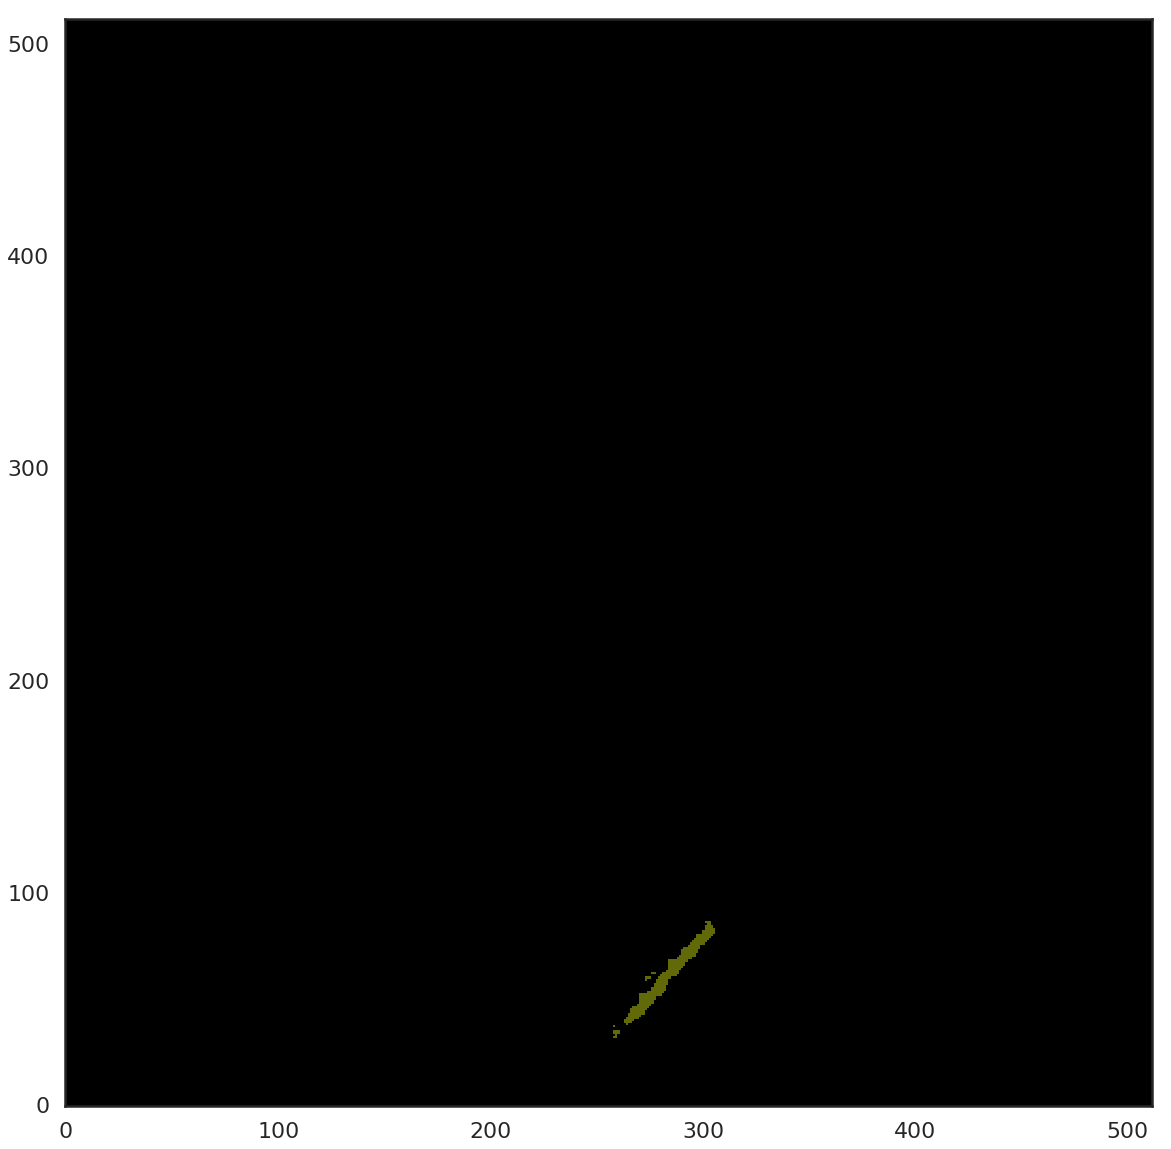

In [6]:
plt.figure(figsize=[20,20])
imagem = np.zeros([512,512,3])
for cluster in clu_tes:
    cluster = clu[0]
    a = np.random.rand(3)
    imagem[cluster[:,0],cluster[:,1]] = a
plt.imshow(imagem,cmap='gray',origin='lower')

In [6]:
clu[4]

array([[  0, 495],
       [  0, 496],
       [  0, 497],
       [  0, 498],
       [  0, 499],
       [  0, 500],
       [  0, 501],
       [  1, 495],
       [  1, 496],
       [  1, 497],
       [  1, 498],
       [  1, 499],
       [  1, 500],
       [  1, 501],
       [  2, 496],
       [  2, 497],
       [  2, 498],
       [  2, 499],
       [  2, 500],
       [  2, 501],
       [  3, 497],
       [  3, 498],
       [  3, 499],
       [  3, 500],
       [  4, 500],
       [  4, 501],
       [  5, 501],
       [  6, 500],
       [  6, 501],
       [  7, 499],
       [  7, 500],
       [  8, 499],
       [  9, 499],
       [  0, 501],
       [  1, 496],
       [  1, 499],
       [  7, 500]])

In [11]:
X[2004]

array([187, 235])

In [28]:
cluster = clu_tes[17]
np.save('iDDBSCAN_plot/clusters/clustertestespyder2.npy',cluster)

In [15]:
t1-t0

499.71659994125366

In [ ]:
#Run 2317
#Evento 12 requer um leve aumento no eps ransac, mas cagaria o resultado do evento 5 por exemplo.
# Eventos que requerem aumento para epsransac = 12, 32, 38 - traço sobreposto que da p tirar algo a mais se aumentar, 41, 50, 57,
# 65, 69, 72, 75, 84
# Eventos que vão ser prejudicados pelo aumento: 

#Eventos pra mostrar: 5, 6, 7, 22 - traços sobrepostos, 23 - traços sobrepostos e bem distantes, 28 - traços sobrepostos,
# 29 - sobreposto mas bom, 34, 38, 39, 62, 82 - sobrpostos que não tinha oq fazer, 93, 95

#Eventos com resultado ruim: 51

#Dar uma olhada no 27, 42, 45, 48, 56, 60, 65, 74, 79, 80, 85

#Eventos em que o fit ficou ruim pq são paralelos ao eixo x: 76, 77

#Eventos que deu problema no ransac: 78

In [ ]:
#Run 2320
#Leve aumento do eps talvez melhore - 02, 07, 14, 19 (Esse aq é nice p mostrar), 20, 25, 26 (Só se aumentasse mt), 
#Eventos sobrepostos - 01, 03, 21 (nice pra mostrar tb), 23 (bom p mostrar tb), 24 (Evento com tracks sobrepostos que mostra bem o problema),

#Dar uma olhada - 05, 12, 31
#Eventos pra mostrar - 06, 11 (nao mudou nada), 

In [ ]:
#Run 2097
#Imagens para mostrar: 18 (TOP DEMAIS, coladinhos e classificados separadamente), 29 (Talvez um exemplo ruim do que pode ser missclassified)

#Run 2098
#Imagens para mostrar: 07 (Bom funcionamento, mas nao o melhor), 12 (overlapped bom), 18 (overlapped que nao tem oq fazer),
#19 (overlapped que nao tem mt oq fazer), 23 (bonzin), 24 (Ilustra bem oq o aumento do eps ransac poderia causar), 29 (bom..)

In [6]:
clusters.labels_[61]

array([-1,  0])

In [ ]:
Tentar olhar o passo a passo do (2317 - 28)